Import all libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

Read the csv file

In [2]:
df = pd.read_csv('../../../Lectures/Lecture 3/data/hw3.csv')
df.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


In [3]:
df = df.sort_values('ts').set_index('ts')
df.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 00:00:00,210.3120,NaN,208.4320,208.6760,70031.618000,NaN,SOL,SOL
2021-12-01 00:00:00,280.5900,281.4000,278.3000,278.7000,207.849000,NaN,COMP,ETH
2021-12-01 00:00:00,257.1020,260.7750,255.3450,257.0780,2730.299000,NaN,AAVE,ETH
2021-12-01 00:00:00,21.2004,21.3115,21.0337,21.2659,12406.133674,NaN,UNI,ETH
2021-12-01 00:00:00,57321.4100,57451.0500,56814.3400,56987.9700,388.482022,NaN,BTC,BTC


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2667 entries, 2021-12-01 00:00:00 to 2021-12-13 06:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2667 non-null   float64
 1   high       2163 non-null   float64
 2   low        2378 non-null   float64
 3   close      2531 non-null   float64
 4   volume     2667 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2667 non-null   object 
 7   chain      2667 non-null   object 
dtypes: float64(6), object(2)
memory usage: 187.5+ KB


In [5]:
len(df[df.duplicated()])

307

In [6]:
def plot_price_ts(df,price = 'close'):
    tokens_in_df = df.token.unique()

    fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

    idx = 0
    for label, df_token in df[['token', price]].groupby('token'):
        df_token[price].plot(ax=axes[idx // 2, idx % 2], label=label)
        axes[idx // 2, idx % 2].legend()

        idx += 1

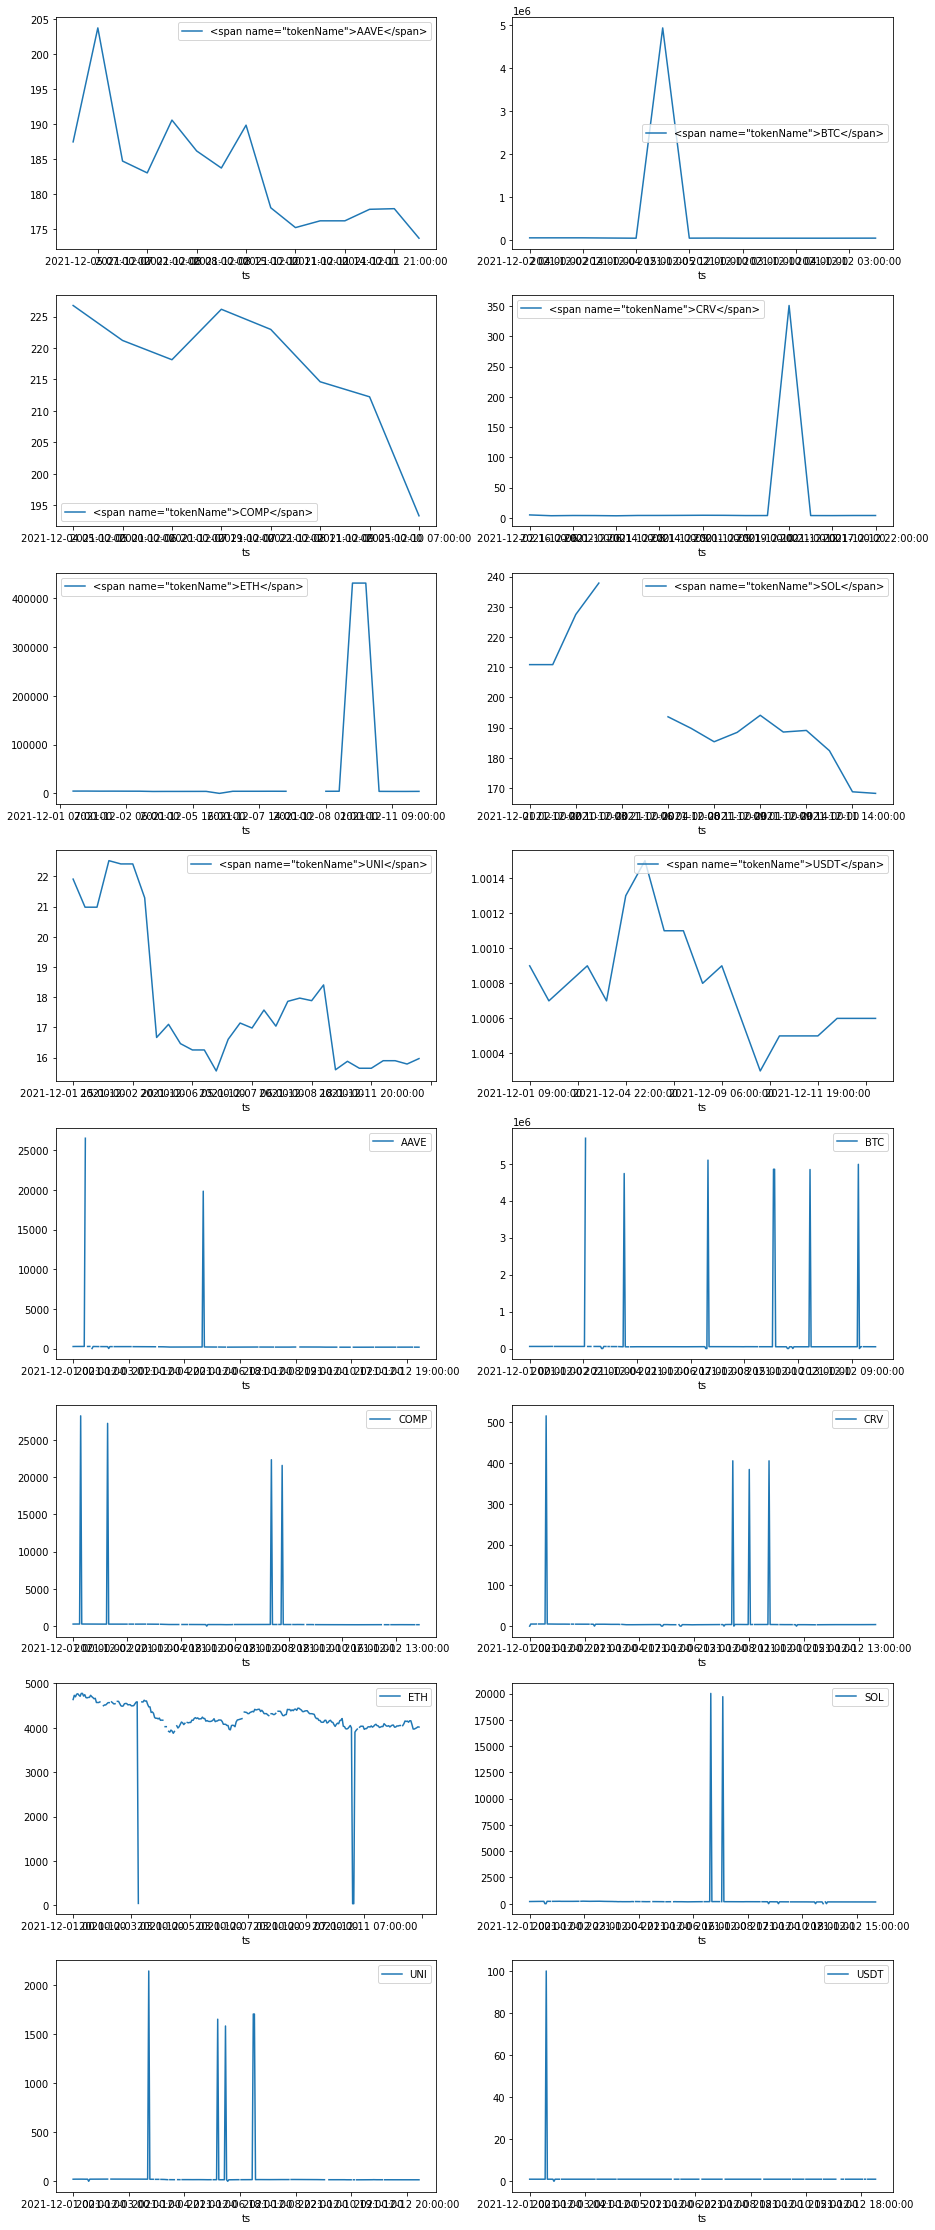

In [7]:
plot_price_ts(df)

Some visible problems within the data:
1. Duplicate values in the data
2. Names of the token are not in the correct format
3. Missing values for the 'close' variable
4. Outlier values for the 'close' variable

1. Removing duplicate values: 

In [8]:
df = df.drop_duplicates()
len(df[df.duplicated()])

0

2. Correcting the format for token names 

In [9]:
df.token.value_counts()

COMP                                  286
BTC                                   283
SOL                                   281
AAVE                                  280
CRV                                   279
USDT                                  278
UNI                                   270
ETH                                   270
<span name="tokenName">ETH</span>      25
<span name="tokenName">UNI</span>      25
<span name="tokenName">USDT</span>     17
<span name="tokenName">CRV</span>      16
<span name="tokenName">AAVE</span>     15
<span name="tokenName">SOL</span>      14
<span name="tokenName">BTC</span>      12
<span name="tokenName">COMP</span>      9
Name: token, dtype: int64

In [10]:
#the method below is not working for some reason, hence using an alternate mathod
#df.loc[df['token'].str.contains('<\/span>'), 'token'].str.extract('<span name=\"tokenName\">(.|\n)*?<\/span>')
df.loc[df['token'].str.contains('<\/span>'), 'token'] = df.loc[df['token'].str.contains('<\/span>'), 'token'].str.replace('<span name=\"tokenName\">','').str.replace('<\/span>','')
df.token.value_counts()

/tmp/ipykernel_8565/4203578080.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[df['token'].str.contains('<\/span>'), 'token'] = df.loc[df['token'].str.contains('<\/span>'), 'token'].str.replace('<span name=\"tokenName\">','').str.replace('<\/span>','')


SOL     295
COMP    295
AAVE    295
UNI     295
BTC     295
ETH     295
USDT    295
CRV     295
Name: token, dtype: int64

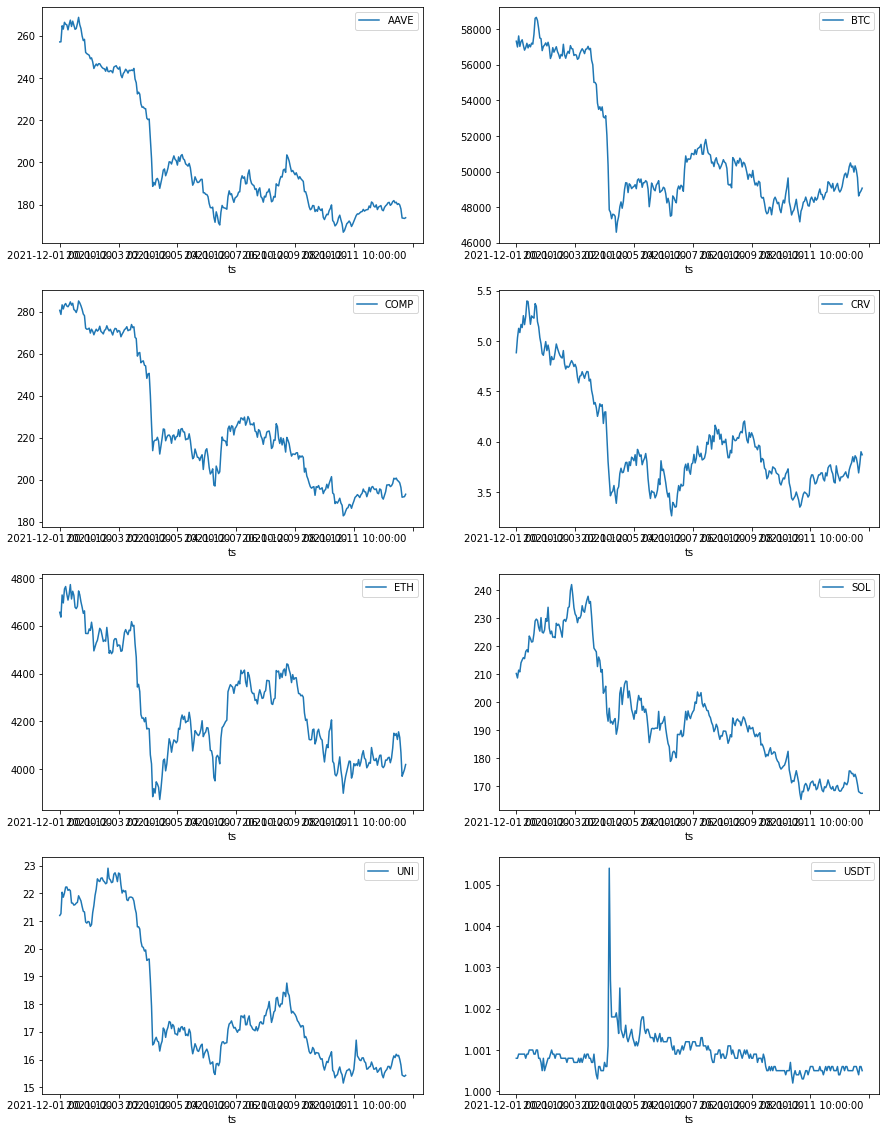

In [11]:
plot_price_ts(df,price='open')

Since, 'open' series is clean without any null values or outliers, we can use the open price of the next period to fill the close price of the current period

3. Filling out the missing values for 'close' using 'next_open'

In [12]:
df['next_open'] = df.groupby('token').open.shift(-1)
df.loc[df['close'].isnull(), 'close'] = df.loc[df['close'].isnull(), 'next_open']

In [13]:
df[df.close.isnull()]

,open,high,low,close,volume,volumeUSD,token,chain,next_open
ts,,,,,,,,,
2021-12-13 06:00:00,3.87,3.87,3.82,NaN,45270.08,NaN,CRV,ETH,NaN


we can't fill the close price of the last timestamp using this method, hence we use (low+high)/2 for this

In [14]:
df.loc[df['close'].isnull(), 'close'] = 0.5 * (df.loc[df['close'].isnull(), 'high'] + df.loc[df['close'].isnull(), 'low'])
len(df[df.close.isnull()])

0

4. Handling outlier values

In [15]:
df.loc[df.close/df.open > 2, 'close'] = df.loc[df.close/df.open > 2, 'next_open']

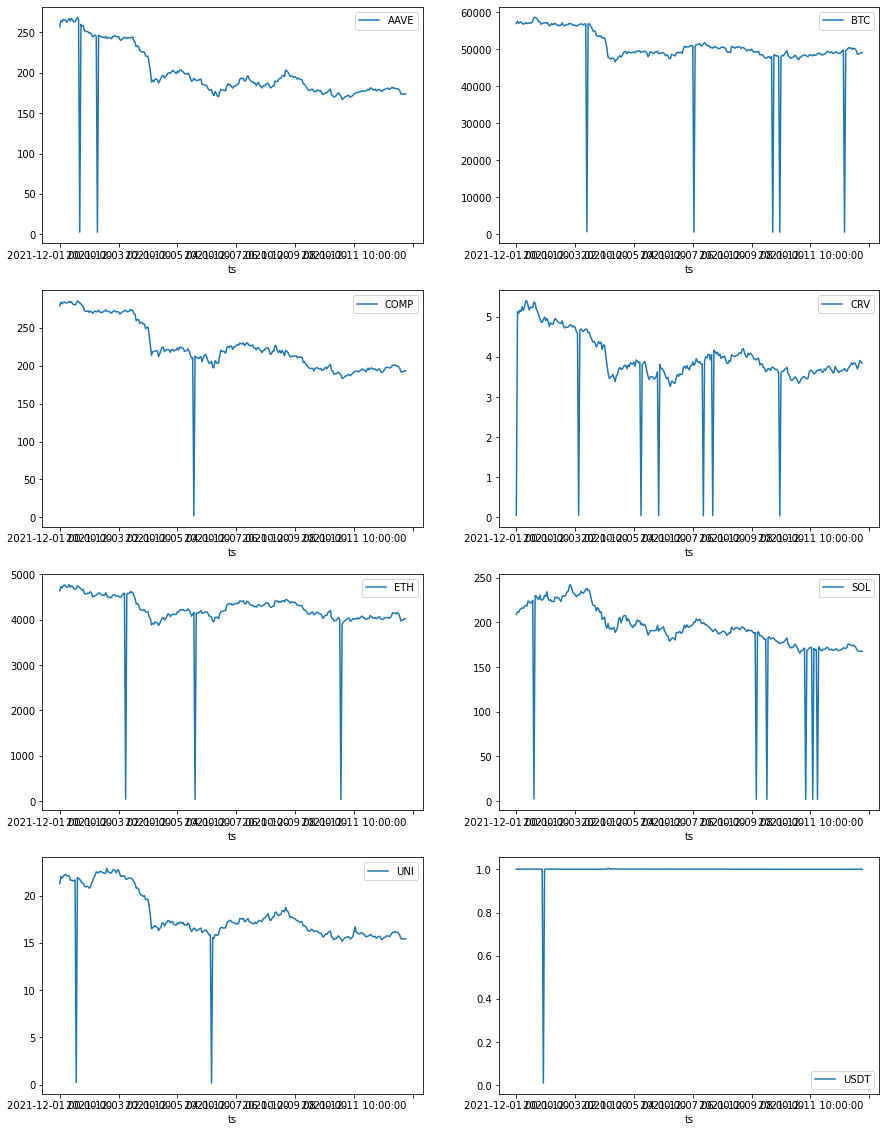

In [16]:
plot_price_ts(df)

Since, there are outliers on the down side as well, we will handle those as well

In [17]:
df.loc[df.close/df.open < 0.5, 'close'] = df.loc[df.close/df.open < 0.5, 'next_open']

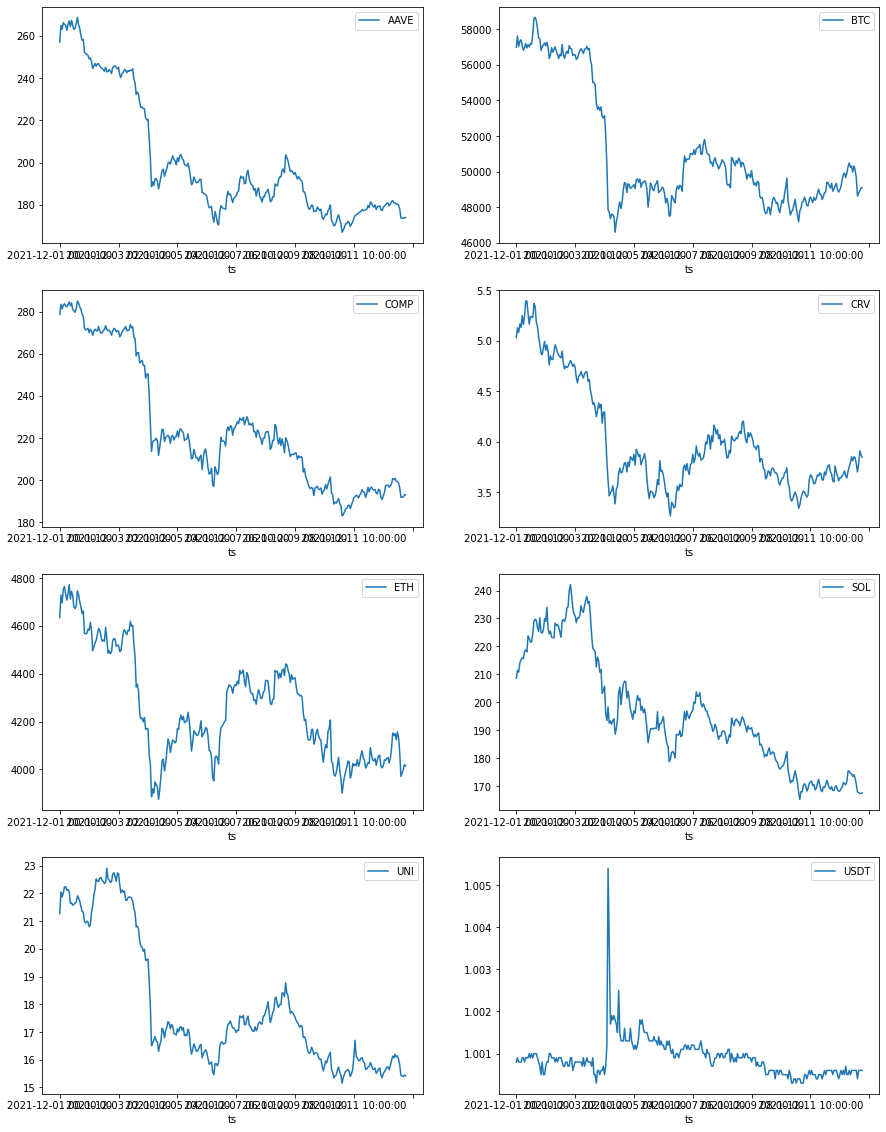

In [18]:
plot_price_ts(df)

Now, the close time series is clean and has sane values

We will calculate the volumeUSD for these

In [19]:
df['volumeUSD'] = df.volume*df.close
df.head()

,open,high,low,close,volume,volumeUSD,token,chain,next_open
ts,,,,,,,,,
2021-12-01 00:00:00,210.3120,NaN,208.4320,208.6760,70031.618000,1.461392e+07,SOL,SOL,208.716
2021-12-01 00:00:00,280.5900,281.4000,278.3000,278.7000,207.849000,5.792752e+04,COMP,ETH,278.650
2021-12-01 00:00:00,257.1020,260.7750,255.3450,257.0780,2730.299000,7.018998e+05,AAVE,ETH,257.149
2021-12-01 00:00:00,21.2004,21.3115,21.0337,21.2659,12406.133674,2.638276e+05,UNI,ETH,21.266
2021-12-01 00:00:00,57321.4100,57451.0500,56814.3400,56987.9700,388.482022,2.213880e+07,BTC,BTC,56998.350


The total traded volume in billion USD for each chain is as follows :

In [20]:
df.groupby('chain').volumeUSD.sum().sort_values(ascending=False).to_frame()*1e-9

,volumeUSD
chain,
ETH,13.655899
BTC,10.959049
SOL,4.078202
USDT,1.007999
